# Drift diffusion modelling of two-choice tasks
This notebook contains exploratory/preliminary drift-diffusion modelling of forced two-chioce tasks from trial by trial cognitive data. Three versions are implemented:
1. EZ ddm - analytical solution utilizing percent correct, mean RT for correct trials, and variance RT for correct trials and validity of results depends on fairly stringent assumptions
2. Hierachical ddm - estimates population/group-level parameters as well as individual-level parameters following Bayesian principles, markov chain monte carlo simulation is used to sample parameters from candidate distributions to identify one best fitting the data (http://ski.clps.brown.edu/hddm_docs/ for more info)
3. Generalized ddm - flexible model which enables assumptions of multiple distributions for each parameter, implemented and described in PyDDM package (https://pyddm.readthedocs.io/en/latest/ for more info)

Dependencies: `hddm`, `ipyparallel`, `paranoid-scientist`, `pyddm`



In [ ]:
# libraries
import numpy as np
from numpy import linspace
import pandas as pd
import seaborn as sns
import glob
import random
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import ipyparallel
import hddm
from ddm import Model, Fittable, Sample
from ddm.functions import fit_adjust_model, display_model
from ddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayPoissonMixture, DriftConstant

In [ ]:
folder = '../ddm'

In [ ]:
def plot_corr(d): 
  sns.set_theme(style="white")
  corr = d.corr()

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def EZ_data(data, s=1):
    """
    Calculate Wagenmaker's EZ-diffusion statistics on data.
    :Arguments:
       data : numpy.array
           Data array with reaction time data. Correct RTs
           are positive, incorrect RTs are negative.
       s : float
           Scaling parameter (default=1)
    :Returns:
      (v, a, ter) : tuple
          drift-rate, threshold and non-decision time
    :See Also: EZ
    """

    try:
        rt = data["rt"]
    except ValueError:
        rt = data

    # Compute statistics over data
    idx_correct = rt > 0
    mrt = np.mean(rt[idx_correct])
    vrt = np.var(rt[idx_correct])
    pc = np.sum(idx_correct) / np.float(rt.shape[0])

    # Calculate EZ estimates.
    return EZ(pc, vrt, mrt, s)


def EZ(pc, vrt, mrt, s=1):
    """
    Calculate Wagenmaker's EZ-diffusion statistics.
    :Parameters:
        pc : float
            probability correct.
        vrt : float
            variance of response time for correct decisions (only!).
        mrt : float
            mean response time for correct decisions (only!).
        s : float
            scaling parameter. Default s=1.
    :Returns:
        (v, a, ter) : tuple
             drift-rate, threshold and non-decision time
    The error RT distribution is assumed identical to the correct RT distrib.
    Edge corrections are required for cases with Pc=0 or Pc=1. (Pc=.5 is OK)
    :Assumptions:
        * The error RT distribution is identical to the correct RT distrib.
        * z=.5 -- starting point is equidistant from the response boundaries
        * sv=0 -- across-trial variability in drift rate is negligible
        * sz=0  -- across-trial variability in starting point is negligible
        * st=0  -- across-trial range in nondecision time is negligible
    :Reference:
        Wagenmakers, E.-J., van der Maas, H. Li. J., & Grasman, R. (2007).
        An EZ-diffusion model for response time and accuracy.
        Psychonomic Bulletin & Review, 14 (1), 3-22.
    :Example:
        >>> EZ(.802, .112, .723, s=.1)
        (0.099938526231301769, 0.13997020267583737, 0.30002997230248141)
    :See Also: EZ_data
    """
    if pc == 0 or pc == 0.5 or pc == 1:
        raise ValueError("Probability correct is either 0%, 50% or 100%")

    s2 = s ** 2
    logit_p = np.log(pc / (1 - pc))

    # Eq. 7
    x = (logit_p * (pc ** 2 * logit_p - pc * logit_p + pc - 0.5)) / vrt
    v = np.sign(pc - 0.5) * s * x ** 0.25
    # Eq 5
    a = (s2 * logit_p) / v

    y = (-v * a) / s2
    # Eq 9
    mdt = (a / (2 * v)) * ((1 - np.exp(y)) / (1 + np.exp(y)))

    # Eq 8
    ter = mrt - mdt

    return (v, a, ter)


# Reaction time distribution plot

In [ ]:
lmt = pd.read_csv(f'{folder}lmt_data.csv')

In [ ]:
lmt.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
lmt.groupby("subj_idx").count()[:5]

,response,rt
subj_idx,,
NDAR_INV003RTV85,28,28
NDAR_INV007W6H7B,29,29
NDAR_INV00BD7VDC,32,32
NDAR_INV00CY2MDM,29,29
NDAR_INV00HEV6HB,30,30


In [ ]:
lmt_test = lmt.iloc[:50000,].copy()
lmt_c = np.where(lmt_test.response == 1, lmt_test.rt, np.nan)
lmt_ic = np.where(lmt_test.response == 0.0, lmt_test.rt, np.nan)
lmt_ic = lmt_ic[~np.isnan(lmt_ic)]

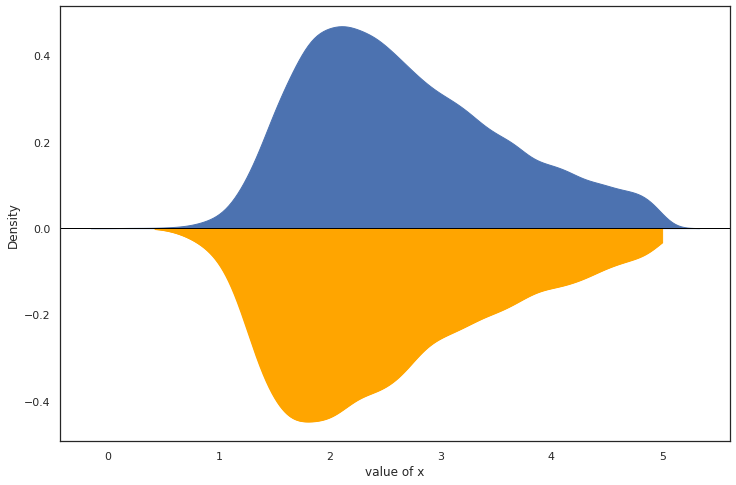

In [ ]:

# Fig size
plt.rcParams["figure.figsize"]=12,8

# plot density chart for var1
sns.kdeplot(data=lmt_c,  fill=True, alpha=1)

# plot density chart for var2
kde = gaussian_kde(lmt_ic)
x_range = linspace(min(lmt_ic), max(lmt_ic), len(lmt_ic))

# multiply by -1 to reverse axis (mirror plot)
sns.lineplot(x=x_range, y=kde(x_range) * -1, color='orange') 
plt.fill_between(x_range, kde(x_range) * -1, color='orange')

# add axis names        
plt.xlabel("value of x")
plt.axhline(y=0, linestyle='-',linewidth=1, color='black')



# show the graph
plt.show()

# EZ

In [ ]:
lmt_test = lmt.query('subj_idx == "NDAR_INV0PJ81CA5"').copy()
lmt_test.rt = lmt_test.rt/1000

In [ ]:
lmt_ez = lmt_test.copy()
lmt_ez.rt = np.where(lmt_ez.response == 1,lmt_ez.rt, -lmt_ez.rt)

(1.746, 4.287)

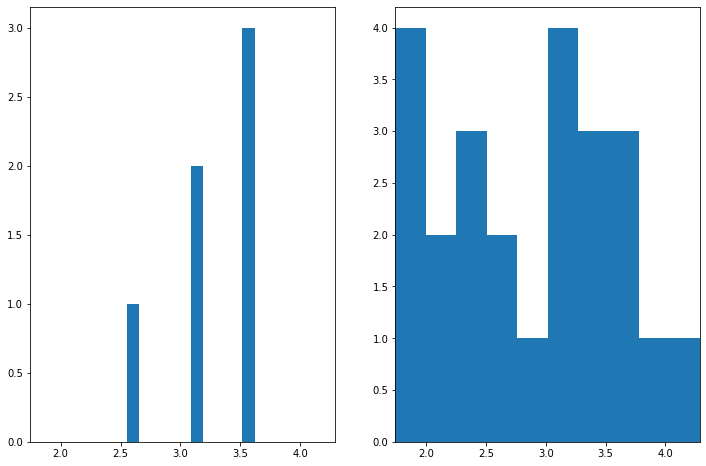

In [ ]:
fig, axs = plt.subplots(1,2)
axs[0].hist(lmt_test.query('response == 0').rt, bins=10)
axs[0].set_xlim([min(lmt_test.rt), max(lmt_test.rt)])
axs[1].hist(lmt_test.query('response == 1').rt, bins=10)
axs[1].set_xlim([min(lmt_test.rt), max(lmt_test.rt)])

# PyDDM

In [ ]:
lmt = pd.read_csv(f'{folder}lmt_data.csv', usecols=['subj_idx', 'response', 'rt']).dropna()
est = pd.read_csv(f'{folder}est_data.csv', usecols=['subj_idx', 'response', 'rt']).dropna()
nb = pd.read_csv(f'{folder}nb_data.csv', usecols=['subj_idx', 'response', 'rt']).dropna()

In [ ]:
lmt.rt = lmt.rt/1000
est.rt = est.rt/1000
nb.rt = nb.rt/1000

In [ ]:
subs = set(lmt.subj_idx.unique()).intersection(est.subj_idx.unique())
subs = subs.intersection(nb.subj_idx.unique())

In [ ]:
lmt = lmt[lmt.rt < 5]

In [ ]:
subs_to_use = list(subs)[:500]

In [ ]:
EZ_data(lmt_ez)

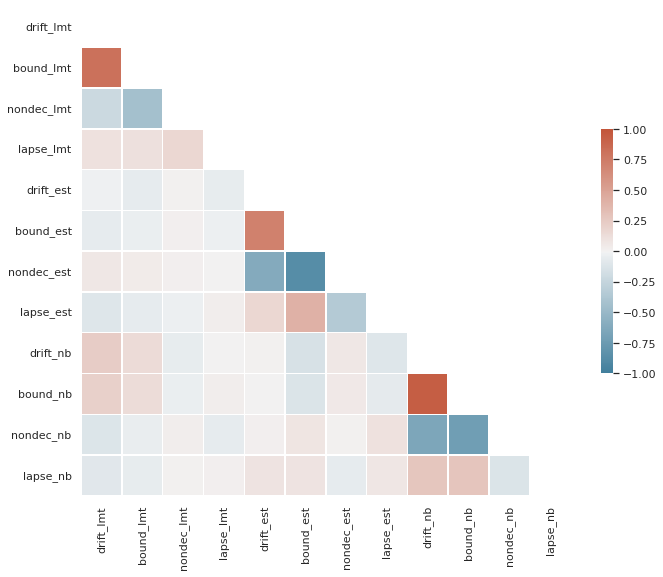

In [ ]:
plot_corr(merged2)

In [ ]:
merged2 = lmt_ddm.merge(est_ddm, on=['subject'], suffixes=['_lmt', ''])
merged2 = merged2.merge(nb_ddm, on=['subject'], suffixes=['_est', '_nb'])

In [ ]:
merged2.corr()

,drift_lmt,bound_lmt,nondec_lmt,lapse_lmt,drift_est,bound_est,nondec_est,lapse_est,drift_nb,bound_nb,nondec_nb,lapse_nb
drift_lmt,1.000000,0.818555,-0.215824,0.105656,-0.015098,-0.057691,0.066348,-0.104094,0.240910,0.214127,-0.112462,-0.086292
bound_lmt,0.818555,1.000000,-0.436189,0.111635,-0.061343,-0.031383,0.043118,-0.059977,0.143822,0.135735,-0.039311,-0.047630
nondec_lmt,-0.215824,-0.436189,1.000000,0.166103,0.010936,0.015951,0.023056,-0.027283,-0.053896,-0.037066,0.024050,0.010017
lapse_lmt,0.105656,0.111635,0.166103,1.000000,-0.050553,-0.025402,0.006692,0.025182,0.003909,0.026928,-0.059324,0.016476
drift_est,-0.015098,-0.061343,0.010936,-0.050553,1.000000,0.716395,-0.615837,0.168445,0.012801,0.006144,0.018733,0.086848
bound_est,-0.057691,-0.031383,0.015951,-0.025402,0.716395,1.000000,-0.869670,0.413846,-0.147584,-0.121093,0.083642,0.092077
nondec_est,0.066348,0.043118,0.023056,0.006692,-0.615837,-0.869670,1.000000,-0.341130,0.065687,0.061953,0.012353,-0.060329
lapse_est,-0.104094,-0.059977,-0.027283,0.025182,0.168445,0.413846,-0.341130,1.000000,-0.103495,-0.065495,0.103065,0.072312
drift_nb,0.240910,0.143822,-0.053896,0.003909,0.012801,-0.147584,0.065687,-0.103495,1.000000,0.944918,-0.650425,0.279584
bound_nb,0.214127,0.135735,-0.037066,0.026928,0.006144,-0.121093,0.061953,-0.065495,0.944918,1.000000,-0.720543,0.282367


In [ ]:
merged.corr()

,drift_lmt,bound_lmt,nondec_lmt,lapse_lmt,drift_est,bound_est,nondec_est,lapse_est,drift_nb,bound_nb,nondec_nb,lapse_nb
drift_lmt,1.000000,0.817757,-0.245594,-0.107373,0.004310,-0.049605,0.065384,-0.073701,0.281430,0.262885,-0.112381,-0.167828
bound_lmt,0.817757,1.000000,-0.467539,-0.093451,-0.033355,-0.016644,0.036715,-0.067667,0.165893,0.172597,-0.018755,-0.099834
nondec_lmt,-0.245594,-0.467539,1.000000,0.002484,-0.020375,-0.012786,0.055670,0.000896,-0.082401,-0.082408,0.037420,0.040023
lapse_lmt,-0.107373,-0.093451,0.002484,1.000000,-0.063889,-0.018531,-0.036847,0.025999,-0.024348,-0.003656,-0.045715,0.030502
drift_est,0.004310,-0.033355,-0.020375,-0.063889,1.000000,0.715681,-0.590923,-0.108579,-0.008939,-0.021996,0.020786,-0.042426
bound_est,-0.049605,-0.016644,-0.012786,-0.018531,0.715681,1.000000,-0.854018,-0.156794,-0.161361,-0.129643,0.051686,0.053161
nondec_est,0.065384,0.036715,0.055670,-0.036847,-0.590923,-0.854018,1.000000,-0.016410,0.090296,0.088461,0.022121,-0.039137
lapse_est,-0.073701,-0.067667,0.000896,0.025999,-0.108579,-0.156794,-0.016410,1.000000,0.087316,0.080677,-0.087365,-0.023827
drift_nb,0.281430,0.165893,-0.082401,-0.024348,-0.008939,-0.161361,0.090296,0.087316,1.000000,0.932451,-0.579187,-0.348484
bound_nb,0.262885,0.172597,-0.082408,-0.003656,-0.021996,-0.129643,0.088461,0.080677,0.932451,1.000000,-0.670095,-0.340607


In [ ]:
from ddm.models import BoundCollapsingExponential, LossRobustBIC, BoundCollapsingLinear

In [ ]:
ddm_cols = ['subject', 'drift', 'bound', 'nondec','lapse']
est_ddm = pd.DataFrame(columns=ddm_cols)
for sub in subs_to_use:
  df = est.query(f'subj_idx == "{sub}"')[['response', 'rt']]
  if df.shape[0] > 45:
    sample = Sample.from_pandas_dataframe(df, rt_column_name="rt", correct_column_name="response")
    model = fit_adjust_model(sample=sample, model=model_est, lossfunction=LossRobustBIC, verbose=False)
    params = model.get_model_parameters()
    row = pd.Series([sub] + [np.float(params[i]) for i in range(4)], index=ddm_cols)
    est_ddm = est_ddm.append(row, ignore_index=True)

In [ ]:
ddm_cols = ['subject', 'drift', 'bound', 'nondec','lapse']
nb_ddm = pd.DataFrame(columns=ddm_cols)
for sub in subs_to_use:
  df = nb.query(f'subj_idx == "{sub}"')[['response', 'rt']]
  if df.shape[0] > 60:
    sample = Sample.from_pandas_dataframe(df, rt_column_name="rt", correct_column_name="response")
    model = fit_adjust_model(sample=sample, model=model_nb, lossfunction = LossRobustBIC, verbose=False)
    params = model.get_model_parameters()
    row = pd.Series([sub] + [np.float(params[i]) for i in range(4)], index=ddm_cols)
    nb_ddm = nb_ddm.append(row, ignore_index=True)

In [ ]:
ddm_cols = ['subject', 'drift', 'bound', 'nondec','lapse']
lmt_ddm = pd.DataFrame(columns=ddm_cols)
for sub in subs_to_use:
  df = lmt.query(f'subj_idx == "{sub}"')[['response', 'rt']]
  if df.shape[0] > 24:
    sample = Sample.from_pandas_dataframe(df, rt_column_name="rt", correct_column_name="response")
    model = fit_adjust_model(sample=sample, model=model_lmt, lossfunction=LossRobustBIC, verbose=False)
    params = model.get_model_parameters()
    row = pd.Series([sub] + [np.float(params[i]) for i in range(4)], index=ddm_cols)
    lmt_ddm = lmt_ddm.append(row, ignore_index=True)

In [ ]:
model.has_analytical_solution()

True

In [ ]:
ddm_cols = ['subject', 'drift', 'bound', 'nondec','lapse']
lmt_ddm = pd.DataFrame(columns=ddm_cols)
for sub in subs_to_use[:10]:
  df = lmt.query(f'subj_idx == "{sub}"')[['response', 'rt']]
  if df.shape[0] > 24:
    sample = Sample.from_pandas_dataframe(df, rt_column_name="rt", correct_column_name="response")
    model = fit_adjust_model(sample=sample, model=model_lmt, lossfunction=LossRobustBIC, verbose=False)
    params = model.get_model_parameters()
    row = pd.Series([sub] + [np.float(params[i]) for i in range(4)], index=ddm_cols)
    lmt_ddm = lmt_ddm.append(row, ignore_index=True)

Params [0.35658351 1.13483616 1.58460404 0.04040551] gave 123.92330552075721
Params [0.91353228 1.53143971 1.60995161 0.03804417] gave 112.07597518953199
Params [0.5313425  1.32405578 1.69799204 0.01      ] gave 119.09021882146345
Params [0.1        1.10494326 1.06170043 0.01      ] gave 130.2876487725488
Params [0.39737277 1.27540316 1.41385351 0.01      ] gave 118.62931675217828
Params [0.64488631 1.35005221 1.56435171 0.04472841] gave 112.16432047566555
Params [0.1        1.09368971 1.30218527 0.01      ] gave 110.70892807745193
Params [0.33136332 1.36558293 1.96465652 0.01      ] gave 120.33444858778489
Params [0.46096341 1.40708724 1.4496259  0.01      ] gave 116.23597323170166
Params [0.1        0.97418958 1.41733192 0.01      ] gave 112.77360821039201


In [ ]:
sample = Sample.from_pandas_dataframe(lmt_test, rt_column_name="rt", correct_column_name="response")

In [ ]:
model_lmt = Model(name='LMT', 
                  drift=DriftConstant(drift=Fittable(minval=.1, maxval=5)),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=Fittable(minval=0.5, maxval=5)),
                  overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=.1, maxval=5)),
                                                OverlayPoissonMixture(pmixturecoef=Fittable(minval=0.01, maxval=.05), rate=1)]),
                 dx=.001, dt=.01, T_dur=5)

In [ ]:
model_est = Model(name='Stroop', 
                  drift=DriftConstant(drift=Fittable(minval=.1, maxval=5)),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=Fittable(minval=0.5, maxval=5)),
                  overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=.1, maxval=5)),
                                                OverlayPoissonMixture(pmixturecoef=Fittable(minval=0.01, maxval=.05), rate=1)]),
                 dx=.001, dt=.01, T_dur=7)

In [ ]:
model_nb = Model(name='NB', 
                  drift=DriftConstant(drift=Fittable(minval=.1, maxval=5)),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=Fittable(minval=0.5, maxval=5)),
                  overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fittable(minval=.1, maxval=5)),
                                                OverlayPoissonMixture(pmixturecoef=Fittable(minval=0.01, maxval=.05), rate=1)]),
                 dx=.001, dt=.01, T_dur=2)

In [ ]:
# Fitting this will also be fast because PyDDM can automatically
# determine that DriftCoherence will allow an analytical solution.
fit_adjust_model(sample=sample, model=model_lmt, verbose=False)

Params [0.29993168 0.97971286 1.82876002 0.5       ] gave 47.4339130106209


Model(name='LMT', drift=DriftConstant(drift=Fitted(0.299931676875417, minval=0.1, maxval=5)), noise=NoiseConstant(noise=1), bound=BoundConstant(B=Fitted(0.9797128560058472, minval=0.5, maxval=5)), IC=ICPointSourceCenter(), overlay=OverlayChain(overlays=[OverlayNonDecision(nondectime=Fitted(1.8287600168862719, minval=0.1, maxval=5)), OverlayPoissonMixture(pmixturecoef=0.02, rate=Fitted(0.5, minval=0.5, maxval=1.5))]), dx=0.01, dt=0.01, T_dur=5, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='Negative log likelihood', value=47.4339130106209, nparams=4, samplesize=29, mess=''))

In [ ]:
params = fit_model.get_model_parameters()

In [ ]:
['lists'] + [np.float(params[i]) for i in range(4)]

['lists', 0.299931676875417, 0.9797128560058472, 1.8287600168862719, 0.5]

In [ ]:
fit_model.has_analytical_solution()

True

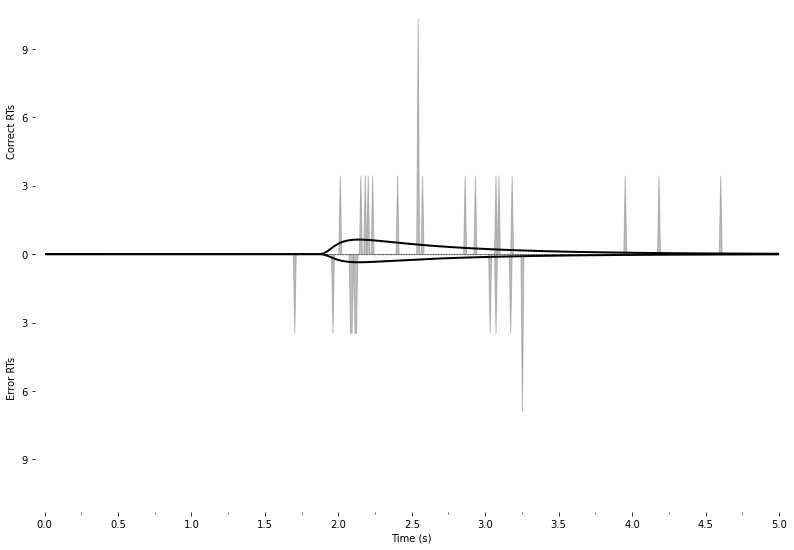

In [ ]:
import ddm.plot
ddm.plot.plot_fit_diagnostics(model=fit_model, sample=sample)
plt.savefig("roitman-fit.png")
plt.show()

In [ ]:
import ddm.plot
model = ddm.Model(drift=DriftLeak(drift=ddm.Fittable(minval=0, maxval=3, default=.1),
                                  leak=ddm.Fittable(minval=-2, maxval=2, default=1)),  
                  noise=ddm.NoiseConstant(noise=ddm.Fittable(minval=.001, maxval=2, default=.5)),
                  bound=ddm.BoundCollapsingExponential(B=ddm.Fittable(minval=.5, maxval=1.5, default=1),
                                                       tau=ddm.Fittable(minval=.1, maxval=5, default=1)),
                  dx=.01, dt=.01, T_dur=2)
ddm.plot.model_gui_jupyter(model=model)

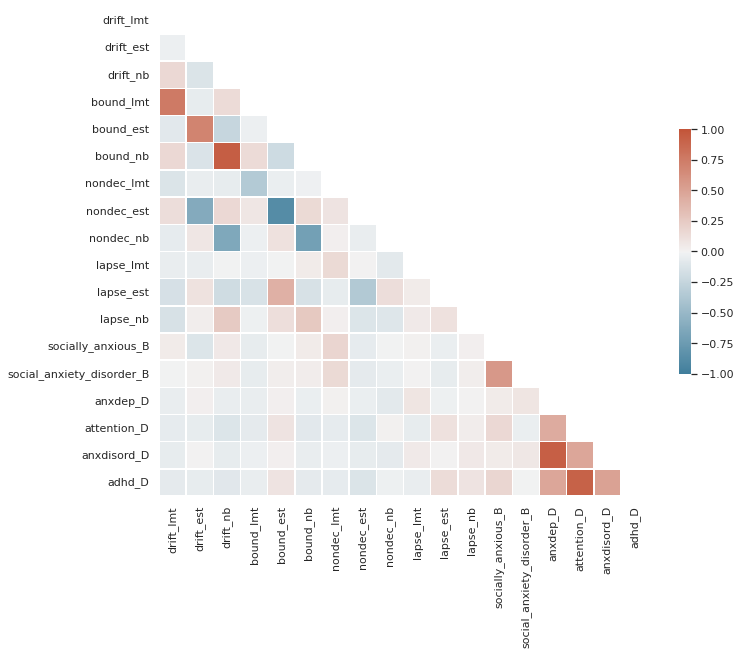

In [ ]:
plot_corr(test_b)

# HDDM

In [ ]:
def extract_dvs(m):
  dvs = {var: m.nodes_db.loc[m.nodes_db.index.str.contains(var + '_subj'), 'mean'] for var in ['a', 'v', 't']}
  subjects = [index.split('.')[1] for index in dvs['a'].index]
  n = len(subjects)
  v = [dvs['v'][i] for i in range(n)]
  a = [dvs['a'][i] for i in range(n)]
  t = [dvs['t'][i] for i in range(n)]
  df = pd.DataFrame(list(zip(subjects, v, a, t)), columns=['subject', 'drift', 'thresh', 'nondec'])
  return df

In [ ]:
lmt.head()

,subj_idx,response,rt
0,NDAR_INVWWWV2AKG,1.0,2.542
1,NDAR_INVWWWV2AKG,1.0,2.198
2,NDAR_INVWWWV2AKG,1.0,2.231
3,NDAR_INVWWWV2AKG,1.0,2.856
4,NDAR_INVWWWV2AKG,0.0,1.700


In [ ]:
lmt = pd.read_csv(f'{folder}lmt_data.csv', usecols=['subj_idx', 'response', 'rt'])

In [ ]:
lmt = pd.read_csv(f'{folder}lmt_data.csv', usecols=['subj_idx', 'response', 'rt'])
sst = pd.read_csv(f'{folder}sst_data.csv', usecols=['subj_idx', 'response', 'rt'])
est = pd.read_csv(f'{folder}est_data.csv', usecols=['subj_idx', 'response', 'rt'])
nb = pd.read_csv(f'{folder}nb_data.csv', usecols=['subj_idx', 'response', 'rt'])

In [ ]:
subs = set(lmt.subj_idx.unique()).intersection(sst.subj_idx.unique())
subs = subs.intersection(est.subj_idx.unique())
subs = subs.intersection(nb.subj_idx.unique())
random.seed = 1
idx = random.sample(range(len(subs)), 100)
subset = np.array(list(subs))[idx]

In [ ]:
random.seed = 1
idx = random.sample(range(len(subs)), 100)
subset = np.array(list(subs))[idx]

In [ ]:
lmt_sample = lmt[lmt.subj_idx.isin(subset)]
lmt_model = hddm.HDDM(lmt_sample)
lmt_model.find_starting_values()
lmt_model.sample(2000, burn=20)

In [ ]:
lmt_hddm = extract_dvs(lmt_model)
lmt_hddm.to_csv('lmt.csv')
files.download('lmt.csv')

In [ ]:
lmt_model.plot_posteriors()

In [ ]:
sst_sample = sst[sst.subj_idx.isin(subset)]
sst_model = hddm.HDDM(sst_sample)
sst_model.find_starting_values()
sst_model.sample(2000, burn=200)

In [ ]:
sst_hddm = extract_dvs(sst_model)

In [ ]:
est_sample = est[est.subj_idx.isin(subset)]
est_model = hddm.HDDM(est_sample)
est_model.find_starting_values()
est_model.sample(2000, burn=200)

In [ ]:
est_hddm = extract_dvs(est_model)

In [ ]:
nb_sample = nb[nb.subj_idx.isin(subset)]
nb_model = hddm.HDDM(nb_sample)

In [ ]:
nb_hddm = extract_dvs(nb_model)